In [1]:
# Command to make `src` module available in notebook
# Details: https://stackoverflow.com/a/35273613

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.cert import CERTDataType, load_dataframe

In [3]:
logon_df = load_dataframe(data_type=CERTDataType.logon)

In [4]:
logon_df.head()

,id,date,user,pc,activity
0,{Q9R3-U1PE27LQ-2164BJLT},01/01/2010 06:20:00,SLW0616,PC-0110,Logon
1,{R1B6-S0LQ34EP-3361QPTV},01/01/2010 06:28:00,RPM0600,PC-9164,Logon
2,{Y3R9-H0JY37RA-5902HXNX},01/01/2010 07:04:00,DAM0170,PC-1525,Logon
3,{D5B1-I6BP26NF-3845HZNZ},01/01/2010 07:23:00,WXW0044,PC-9422,Logon
4,{I0N6-I9PB69SZ-5272SLAT},01/01/2010 07:31:00,RLD0349,PC-1290,Logon


In [5]:
len(set(logon_df['user']))

1000

In [6]:
import pandas as pd

def get_user_logon_activities(user: str, data: pd.DataFrame) -> pd.DataFrame:
    return data.query(f'user == "{user}" and activity == "Logon"')

In [7]:
activities = get_user_logon_activities('SLW0616', logon_df)

In [8]:
activities.head()

,id,date,user,pc,activity
0,{Q9R3-U1PE27LQ-2164BJLT},01/01/2010 06:20:00,SLW0616,PC-0110,Logon
359,{K6E6-O7JH94TK-3163KUIG},01/04/2010 06:18:00,SLW0616,PC-0110,Logon
1539,{J0Q3-F2YL74NZ-4745AZHS},01/04/2010 12:09:02,SLW0616,PC-0110,Logon
2856,{D9C8-E1AQ01LJ-7275RQMV},01/05/2010 06:23:00,SLW0616,PC-0110,Logon
4013,{V3C9-U7AB24ZH-4889PFMX},01/05/2010 12:18:58,SLW0616,PC-0110,Logon


In [9]:
len(logon_df)

845351

In [10]:
from datetime import datetime

def generate_user_logon_profile(user: str, data: pd.DataFrame) -> list[float]:
    """
    Формирует вектор из 48 чисел, где каждое – частота залогина в какой-либо час дня
    Числа 1-24 соответствуют будним дням, числа 25-48 – выходным
    """
    weekend_offset = 24
    profile = [0 for _ in range(48)]
    rows = get_user_logon_activities(user, data)
    for _, row in rows.iterrows():
        timestamp = datetime.strptime(row['date'], '%m/%d/%Y %H:%M:%S')
        if timestamp.weekday() in (5, 6):
            profile[timestamp.hour + weekend_offset] += 1
        else:
            profile[timestamp.hour] += 1
    
    total_activities = sum(profile)
    return [x / total_activities for x in profile]


def get_user_logon_profiles(logon_data: pd.DataFrame) -> list[tuple[str, list[int]]]:
    users = set(logon_data['user'])
    return [
        (user, generate_user_logon_profile(user, logon_data))
        for user in users
    ]


In [11]:
profiles = get_user_logon_profiles(logon_df)

In [12]:
from sklearn.cluster import DBSCAN
import numpy as np


X = np.array([v for _, v in profiles])
clustering = DBSCAN(eps=0.2, min_samples=2).fit(X)

In [13]:
profiles_w_cluster_id = list(zip(clustering.labels_, profiles))

In [15]:
set(clustering.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [16]:
ldap_df = load_dataframe(CERTDataType.ldap)

In [17]:
ldap_df.head()

,employee_name,user_id,email,role,business_unit,functional_unit,department,team,supervisor
0,Sara Indigo Berger,SIB0825,Sara.Indigo.Berger@dtaa.com,Salesman,1,5 - SalesAndMarketing,2 - Sales,5 - RegionalSales,Regan Kirestin Frye
1,Nerea Ingrid Good,NIG0433,Nerea.Ingrid.Good@dtaa.com,ProductionLineWorker,1,3 - Manufacturing,3 - Assembly,2 - AssemblyDept,Hilel Colt Rush
2,Maggy Maryam Newman,MMN0579,Maggy.Maryam.Newman@dtaa.com,Salesman,1,5 - SalesAndMarketing,2 - Sales,3 - RegionalSales,Dorian Dominic Burt
3,Asher Lucas Daniel,ALD0521,Asher.Lucas.Daniel@dtaa.com,Mathematician,1,2 - ResearchAndEngineering,1 - Research,3 - Lab,Elizabeth Josephine Gay
4,Jael Phyllis Contreras,JPC0464,Jael.Phyllis.Contreras@dtaa.com,Salesman,1,5 - SalesAndMarketing,2 - Sales,2 - RegionalSales,Brandon Vladimir Vaughan


In [41]:
def get_user_role(user: str):
    row = ldap_df.query(f'user_id == "{user}"')
    return set(row['role']).pop()

get_user_role('AHS0228')

'SoftwareEngineer'

In [43]:
from collections import Counter, defaultdict


cluster_to_role = defaultdict(list)

for cid, (user, _) in profiles_w_cluster_id:
    cluster_to_role[cid].append(get_user_role(user))

In [45]:
for k, v in cluster_to_role.items():
    print(k, Counter(v))

0 Counter({'ProductionLineWorker': 49, 'Salesman': 23, 'SoftwareEngineer': 19, 'Scientist': 12, 'ComputerScientist': 8, 'ComputerProgrammer': 8, 'Mathematician': 6, 'ElectricalEngineer': 5, 'AdministrativeAssistant': 5, 'Manager': 5, 'Technician': 3, 'TestEngineer': 3, 'MechanicalEngineer': 3, 'LabManager': 2, 'Director': 2, 'Physicist': 2, 'FinancialAnalyst': 2, 'AssemblySupervisor': 2, 'InstructionalCoordinator': 1, 'ComputerTrainer': 1, 'Statistician': 1, 'TechnicalTrainer': 1, 'ManagementTrainer': 1})
1 Counter({'Technician': 18, 'IndustrialEngineer': 4, 'HumanResourceSpecialist': 2, 'Accountant': 2, 'Manager': 1, 'Director': 1})
2 Counter({'ProductionLineWorker': 41, 'SoftwareEngineer': 15, 'Salesman': 7, 'Scientist': 5, 'ComputerProgrammer': 5, 'Physicist': 4, 'Mathematician': 4, 'ComputerScientist': 4, 'ElectricalEngineer': 3, 'AdministrativeAssistant': 2, 'FinancialAnalyst': 1, 'Director': 1, 'Manager': 1, 'ComputerTrainer': 1, 'ChiefEngineer': 1, 'Statistician': 1, 'TestEngine

In [54]:
all_roles = list(set(sum([v for v in cluster_to_role.values()], [])))

In [57]:
data = [
    [Counter(cluster_to_role[cid])[role] for role in all_roles]
    for cid in cluster_to_role.keys()
]

<AxesSubplot:>

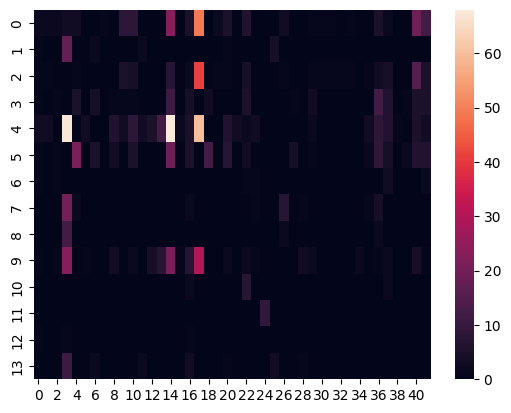

In [59]:
import seaborn

seaborn.heatmap(data)

In [60]:
for idx, role in enumerate(all_roles):
    print(idx, role)

0 Director
1 AssemblySupervisor
2 LabManager
3 Technician
4 MechanicalEngineer
5 HardwareEngineer
6 HumanResourceSpecialist
7 TechnicalTrainer
8 PurchasingClerk
9 ComputerProgrammer
10 ComputerScientist
11 Accountant
12 MaterialsEngineer
13 SystemsEngineer
14 Salesman
15 HealthSafetyEngineer
16 AdministrativeAssistant
17 ProductionLineWorker
18 SecurityGuard
19 FinancialAnalyst
20 Manager
21 NursePractitioner
22 Mathematician
23 VicePresident
24 ITAdmin
25 IndustrialEngineer
26 TestEngineer
27 Engineer
28 FieldServiceEngineer
29 Statistician
30 ManagementTrainer
31 InstructionalCoordinator
32 President
33 ComputerTrainer
34 AdministrativeStaff
35 ChiefEngineer
36 ElectricalEngineer
37 Physicist
38 Nurse
39 Attorney
40 SoftwareEngineer
41 Scientist
